# Gaussian mixture model

When we have a complex data distribution and want to describe it in a parametric way, we can use several Gaussians instead of one.

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

We start with some, reassonably weird, data.

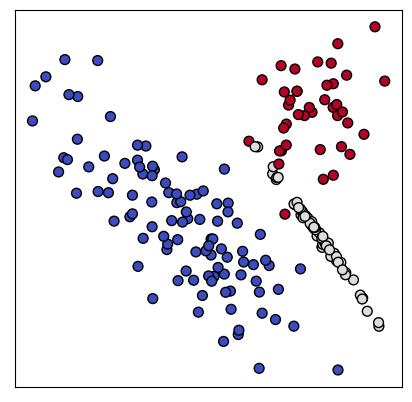

In [2]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=200, n_features=2, n_informative=2,
                           n_redundant=0, n_classes=3, n_clusters_per_class=1,
                           weights=[.5, .3, .2], random_state=4)

plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k', cmap='coolwarm')
plt.xticks([])
plt.yticks([])
plt.show()

Since we generated the data, we know the component labels for all samples. Using these, we can plot level sets for the sampled distributions.

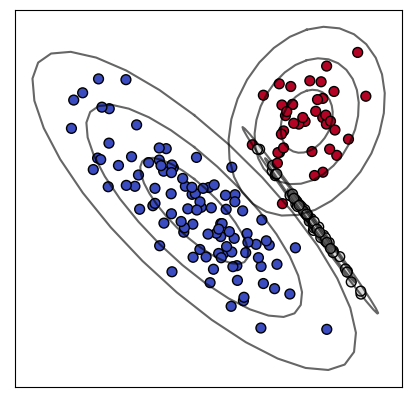

In [3]:
def level(mu, C, radius, points=30):
  """Returns coordinates for a mahalanobis distance level of the distribution"""
  V = np.linalg.cholesky(C)
  t = np.linspace(0, 2*np.pi, points)
  A = np.concatenate([np.vstack(np.sin(t)*radius), np.vstack(np.cos(t)*radius)], axis=1)
  Y = np.matmul(V, A.T).T
  Y[:, 0] += mu[0]
  Y[:, 1] += mu[1]
  return Y

plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k', cmap='coolwarm')
for c in np.unique(y):
  mu = np.mean(X[y==c, :], axis=0)
  C = np.cov(X[y==c, :].T)
  for sd in [1, 2, 3]:
    circle = level(mu, C, sd)
    plt.plot(circle[:, 0], circle[:, 1], 'k', alpha=.6)#, colormap='coolwarm')
plt.xticks([])
plt.yticks([])
plt.show()

Now, lets assume we don't have the labels for this data. How can we estimate the densities then?

In [4]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type='full')
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

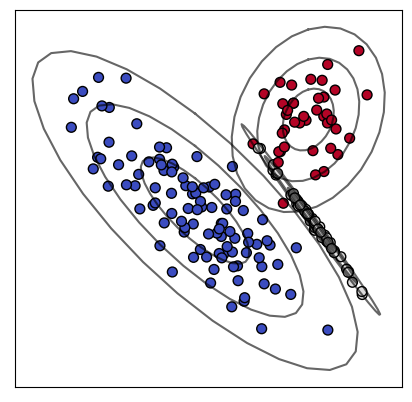

In [5]:
plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k', cmap='coolwarm')
for i in range(len(gmm.means_)):
  for sd in [1, 2, 3]:
    circle = level(gmm.means_[i], gmm.covariances_[i], sd)
    plt.plot(circle[:, 0], circle[:, 1], 'k-', alpha=.6)
plt.xticks([])
plt.yticks([])
plt.show()

I have implemented the EM algorithm using the equations from the slides.

In [6]:
class GMM(object):
  def __init__(self, n_components, n_iter=100, alpha=1):
    """Homemade GMM

    n_components: The number of mixture components
    n_iter: Training iterations, exit criterion is not implemented
    alpha: learning rate, for nicer animations
    """
    self.n_components_ = n_components
    self.n_iter_ = n_iter
    self.alpha_ = alpha

  def fit(self, X):
    self.n_dim_ = X.shape[1]
    self.means_ = [np.random.uniform(-1, 1, size=self.n_dim_) for i in range(self.n_components_)]
    self.covariances_ = [np.eye(self.n_dim_) for i in range(self.n_components_)]
    self.pi_ = np.ones(self.n_components_) / self.n_components_
    for iter in range(self.n_iter_):
      self._fit(X)
    return self

  def _fit(self, X):
    # E step
    gamma = np.zeros((X.shape[0], self.n_components_))
    # Find likelihoods for each point and component
    for i in range(self.n_components_):
      gamma[:, i] = self.pi_[i]*multivariate_normal.pdf(X, mean=self.means_[i],
                                                        cov=self.covariances_[i])
    # Normalize likelihoods per component
    for i in range(X.shape[0]):
      gamma[i, :] /= np.sum(gamma[i, :])
    # M step
    for i in range(self.n_components_):
      self.pi_[i] = self.alpha_*np.sum(gamma[:, i])/np.sum(gamma.ravel()) + (1-self.alpha_)*self.pi_[i]
      w = gamma[:, i]/np.sum(gamma[:, i])
      self.means_[i] = self.alpha_*np.average(X, axis=0, weights=w) + (1-self.alpha_)*self.means_[i]
      self.covariances_[i] = self.alpha_*np.cov(X.T, aweights=w) + (1-self.alpha_)*self.covariances_[i]

In [7]:
# We need imagemagick to write a gif animation at the end
!apt-get install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.9).
0 upgraded, 0 newly installed, 0 to remove and 17 not upgraded.


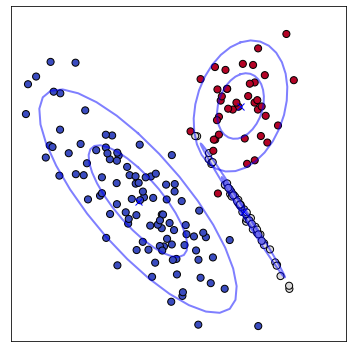

In [8]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

gmm = GMM(n_components=3, n_iter=0).fit(X)

fig = plt.figure(figsize=(5, 5))
ax = fig.subplots(1, 1)
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm', edgecolor='k')
l, = ax.plot([gmm.means_[i][0] for i in range(gmm.n_components_)], [gmm.means_[i][1] for i in range(gmm.n_components_)], 'bx', linewidth=3, markersize=7)
circles = list()
j = 0
for i in range(gmm.n_components_):
  for sd in [1, 2]:
    Y = level(gmm.means_[i], gmm.covariances_[i], sd)
    c, = ax.plot(Y[:, 0], Y[:, 1], 'b-', linewidth=2, alpha=.5)
    circles.append(c)
    j += 1
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()

def update(i):
  # Run a step in the EM training
  gmm._fit(X)
  # Update graphics
  l.set_data([gmm.means_[i][0] for i in range(gmm.n_components_)], [gmm.means_[i][1] for i in range(gmm.n_components_)])
  j = 0
  for i in range(gmm.n_components_):
    for sd in [1, 2]:
      Y = level(gmm.means_[i], gmm.covariances_[i], sd)
      circles[j].set_data(Y[:, 0], Y[:, 1])
      j += 1

anim = FuncAnimation(fig, update, frames=60)
HTML(anim.to_jshtml(fps=15))
# anim.save('gmm.gif', writer='imagemagick', fps=15)
# ani.to_html5_video()